<a href="https://colab.research.google.com/github/eTeReBeReTe/Stock-Price-Prediction-using-LSTM-and-Technical-Indicators/blob/main/Price%20Prediction%20using%20LSTM%20and%20TA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 35.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 118.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.18.1-cp311-cp311-linux_x86_64.whl size=886615 sha256=60badece6fc8a61d6c44394b03ca615ef0aca9080655559df1989b87819ea0ca
  Stored in directory: /root/.cache/pip/wheels/25/cb/79/a133a0d1d75f318a96614ed7fb97bdf2f35a7b6c4d4e426e3f
Successfully built peewee
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [5]:
!pip install tensorflow

  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 600.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.1 MB/s eta 0:00:00
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import math
import yfinance as yf
import tensorflow as tf

In [7]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.layers import Dense
from tensorflow.keras import layers, models, optimizers
import keras_tuner as kt

In [47]:
START = "2000-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Define a function to load the dataset

def load_data(ticker):
    stock = yf.Ticker(ticker)
    data = stock.history(start=START, end=TODAY, auto_adjust = False)
    #data = yf.download(ticker, START, TODAY)
    data['Company Name'] = stock.info['longName']
    data.reset_index(inplace=True)
    data['Date'] = data['Date'].dt.tz_localize(None)  # drop the timezone
    #data['Date'] = data['Date'].dt.date                # cast to plain date
    # **make Date the index**
    data.set_index('Date', inplace=True)
    return data

In [48]:
df = load_data('TSLA')
data=df.drop(columns=["Dividends", "Stock Splits"])
data.head()

,Open,High,Low,Close,Adj Close,Volume,Company Name
Date,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,"Tesla, Inc."
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,"Tesla, Inc."
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,"Tesla, Inc."
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,"Tesla, Inc."
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,"Tesla, Inc."


In [49]:
data = data[['Adj Close']]
data.columns = ['Price']
data.head()

,Price
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [50]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 3753 number of days in the dataset.


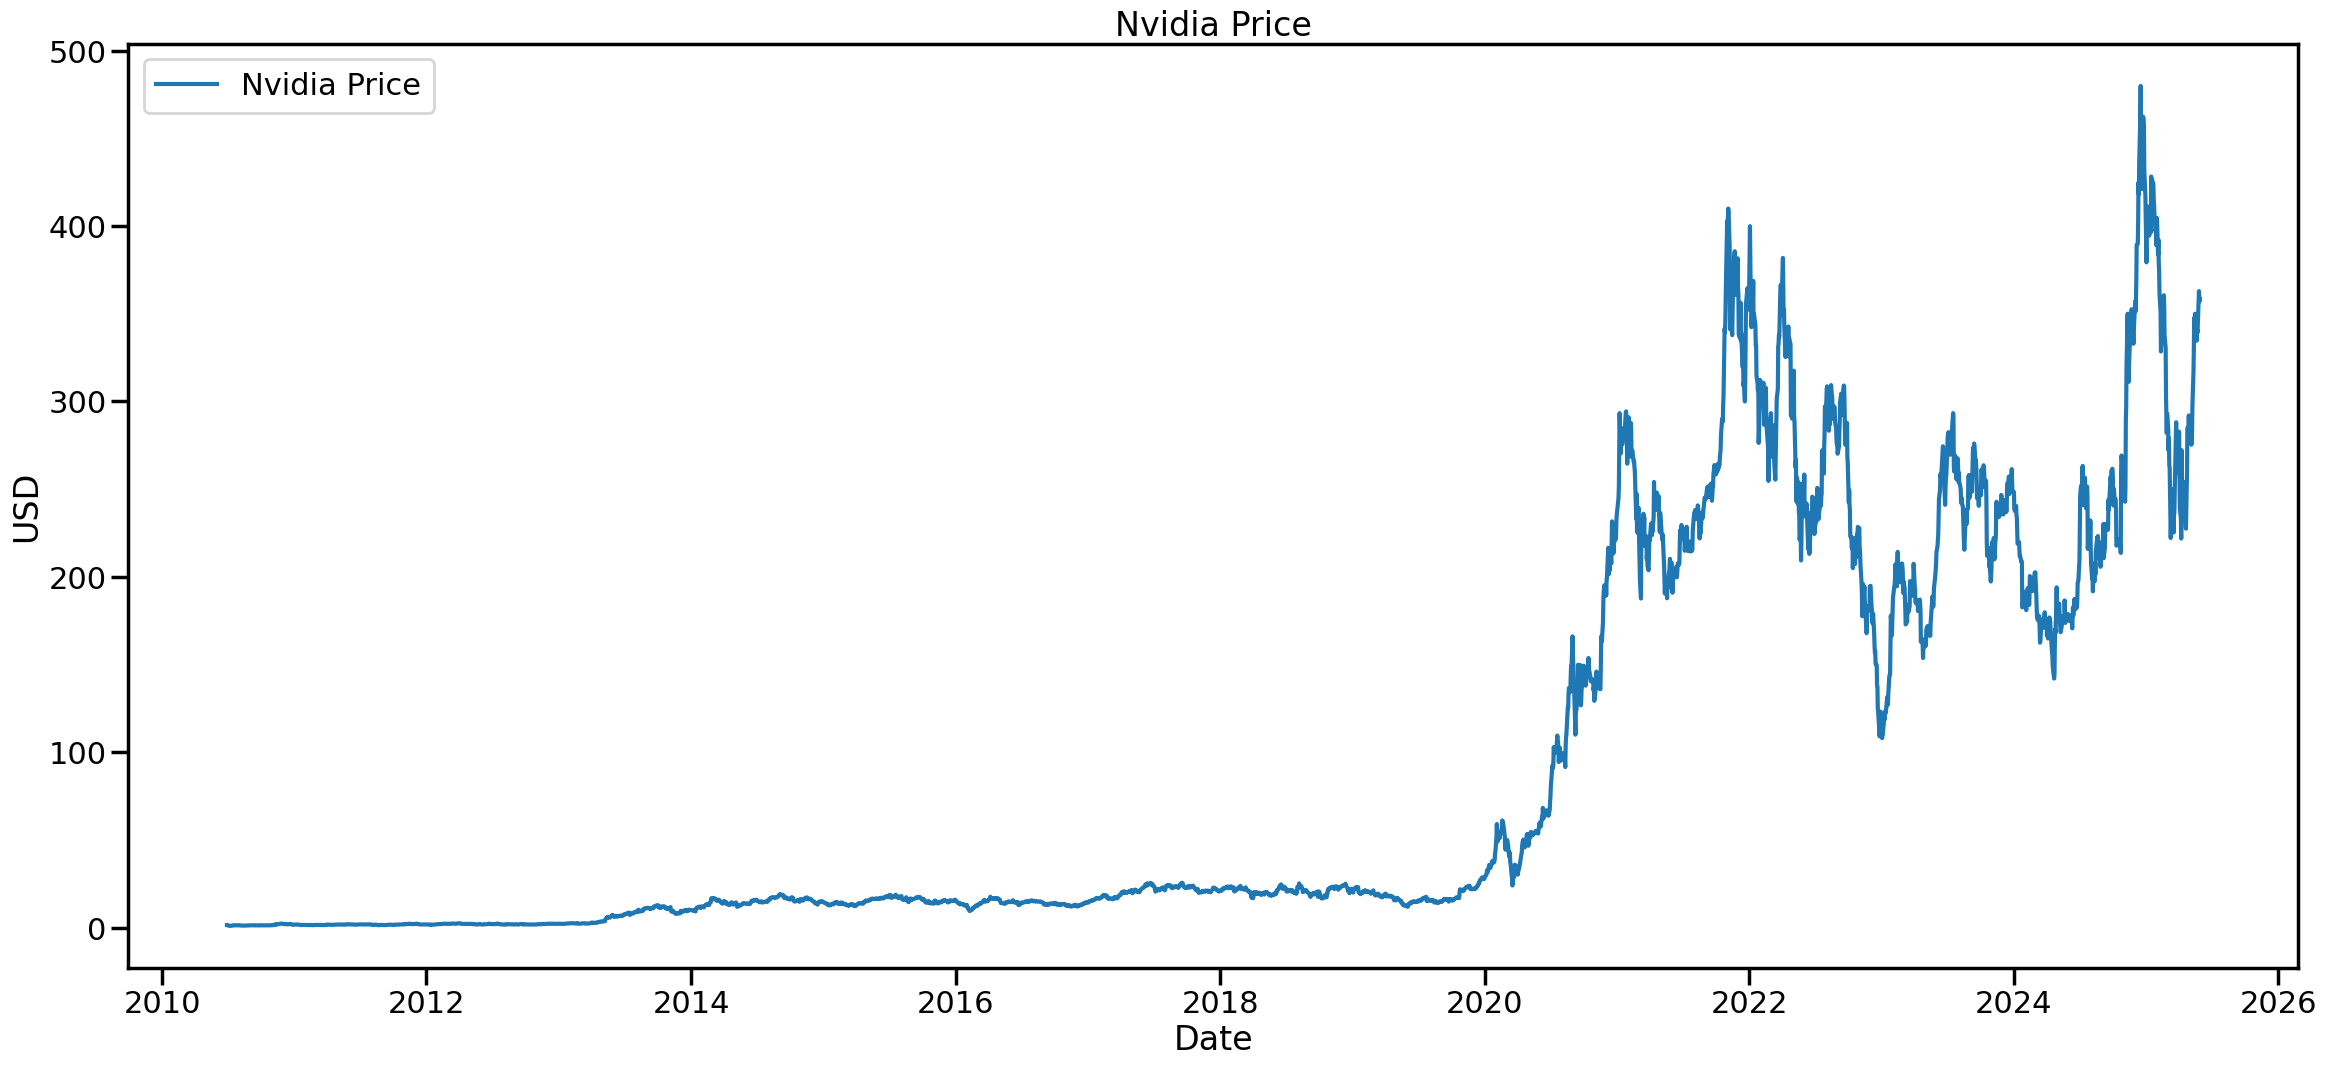

In [51]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Price'], label='Nvidia Price')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Nvidia Price')
plt.legend()
plt.show()

In [52]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()

    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['Price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [53]:
df = get_technical_indicators(data)

In [54]:
df = df.dropna()
df.head()

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2010-07-28,1.381333,1.381238,1.327460,1.340849,1.360547,0.019699,0.149731,1.626922,1.027999,1.380945,0.381333,-0.964082
2010-07-29,1.356667,1.381714,1.316222,1.342285,1.359935,0.017650,0.137159,1.590540,1.041904,1.364760,0.356667,-1.030953
2010-07-30,1.329333,1.379048,1.303873,1.341128,1.355124,0.013995,0.122269,1.548411,1.059335,1.341142,0.329333,-1.110686
2010-08-02,1.394667,1.378286,1.300571,1.345837,1.361320,0.015483,0.118611,1.537793,1.063350,1.376825,0.394667,-0.929713
2010-08-03,1.463333,1.384571,1.309302,1.356028,1.377259,0.021231,0.123660,1.556622,1.061981,1.434497,0.463333,-0.769309


In [55]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Tesla - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

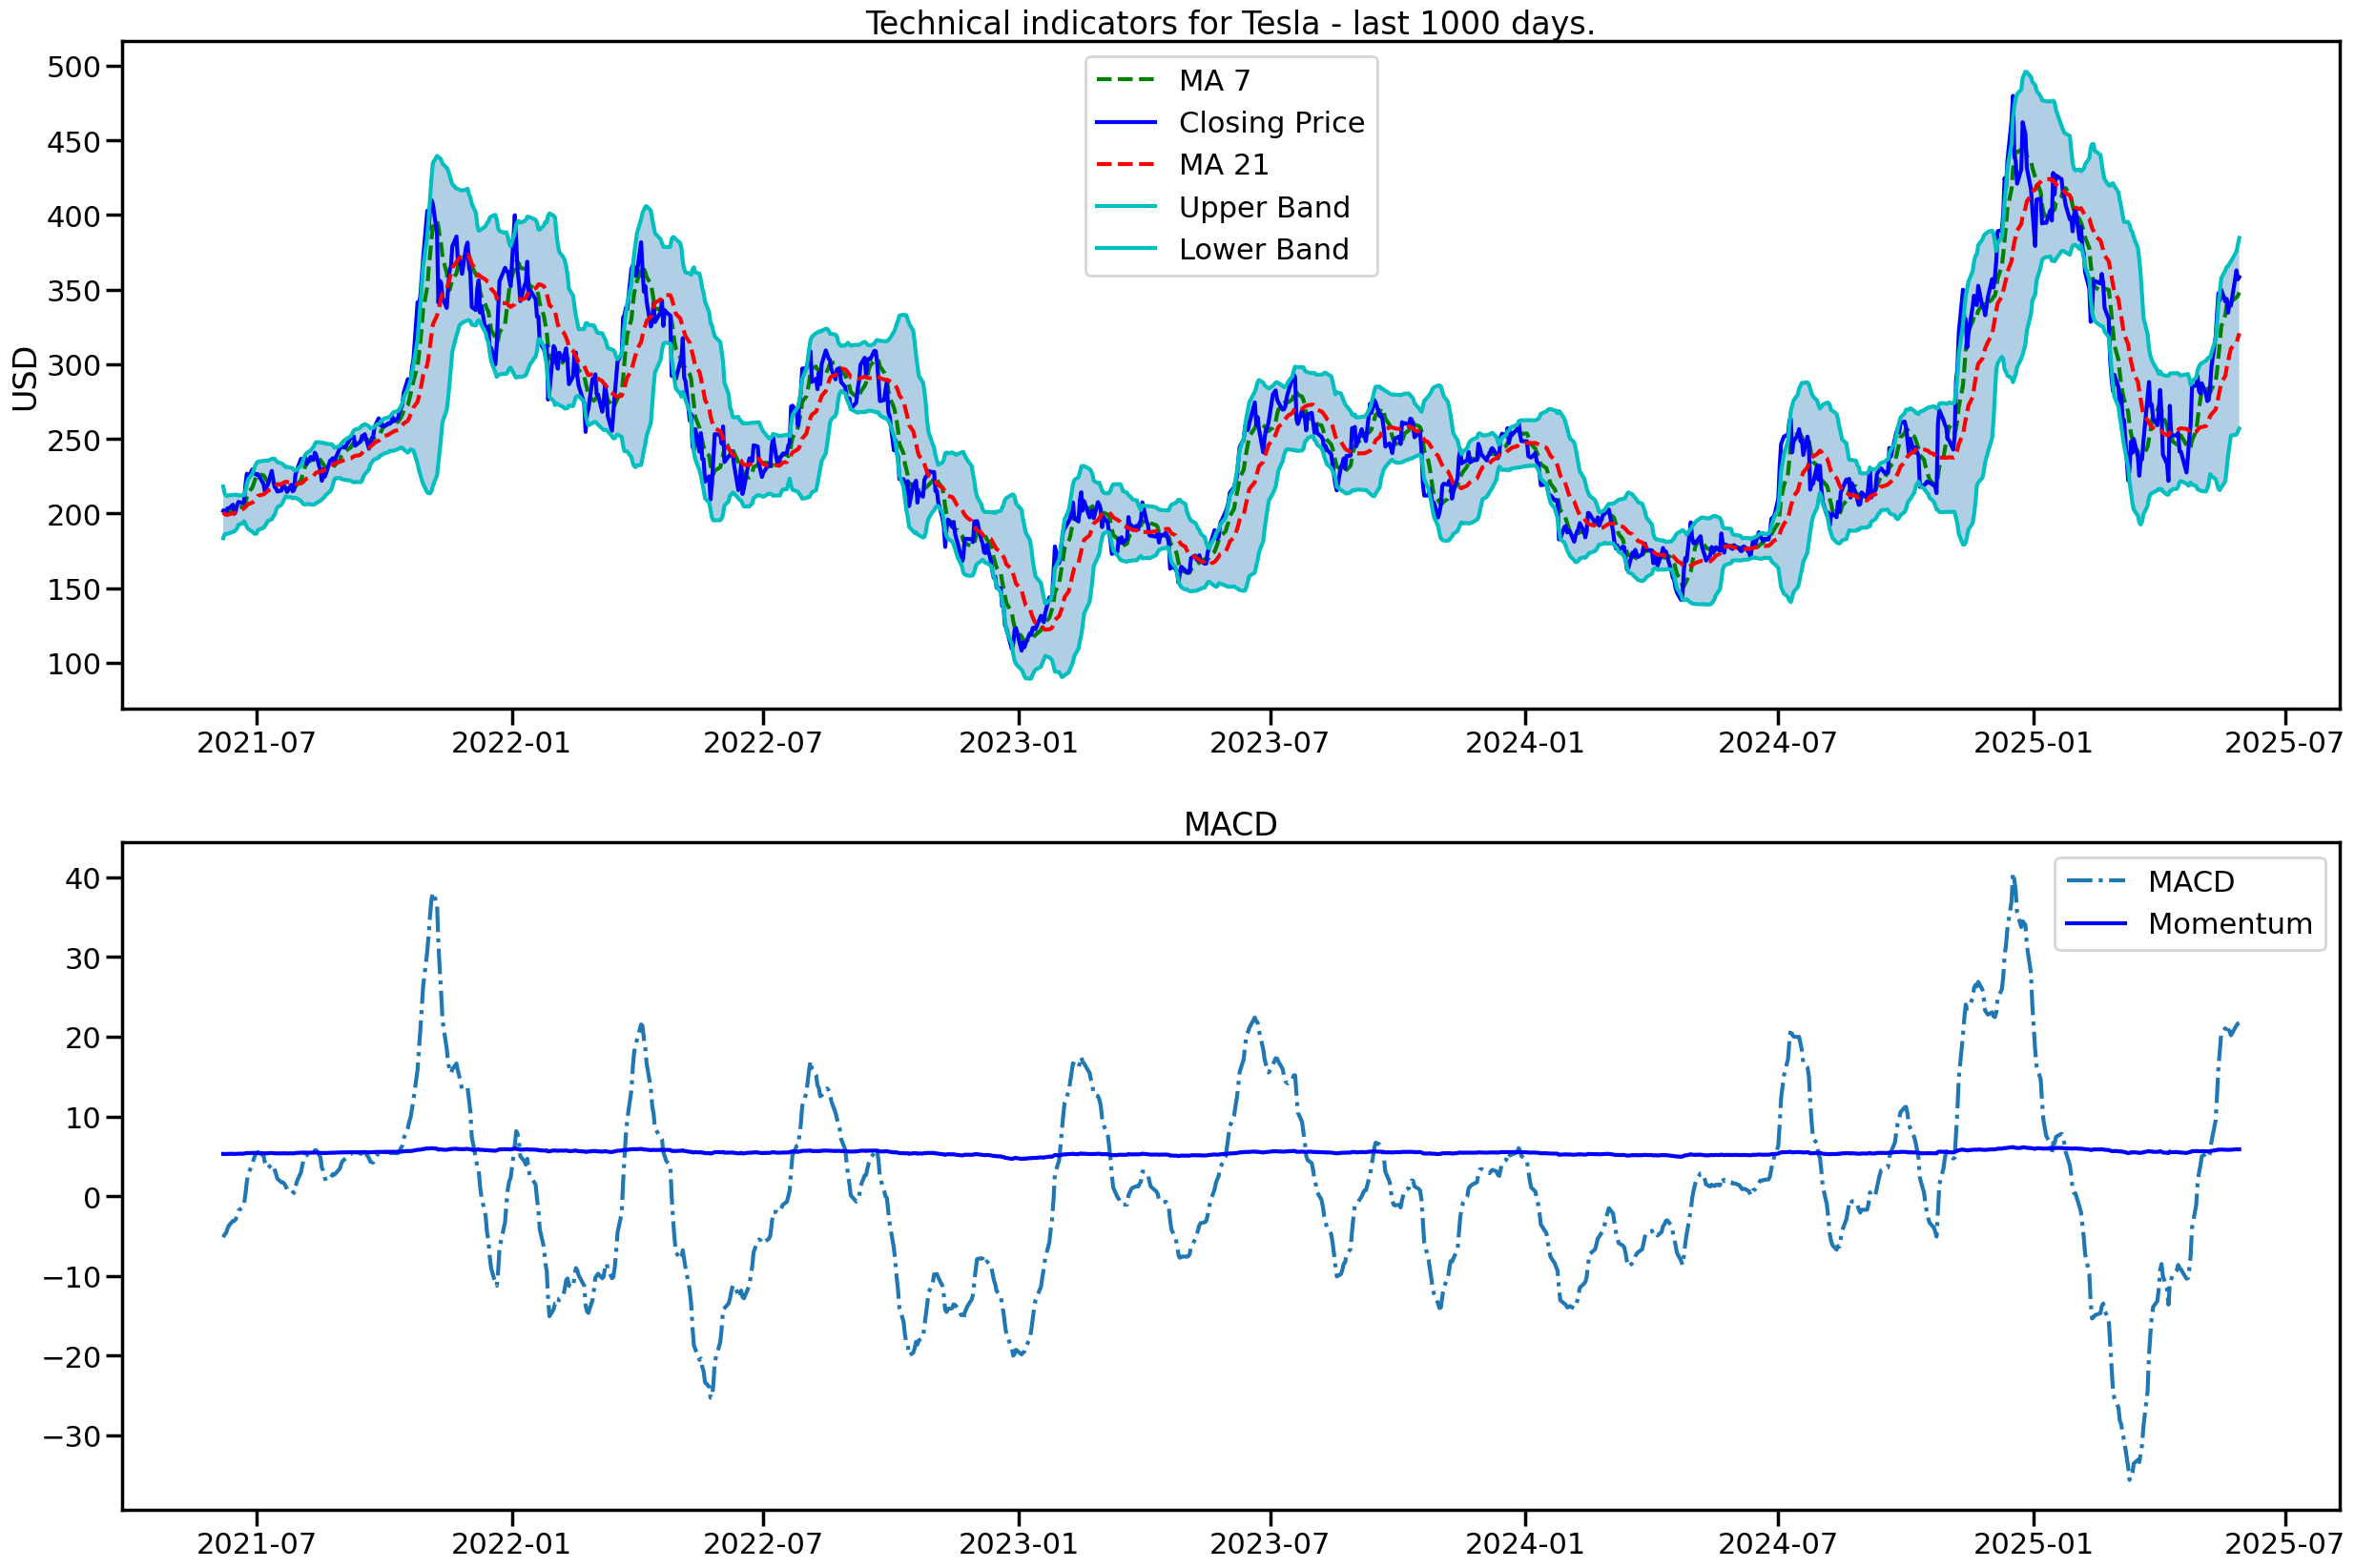

In [56]:
plot_technical_indicators(df, 1000)

Text(0.5, 1.0, 'Params')

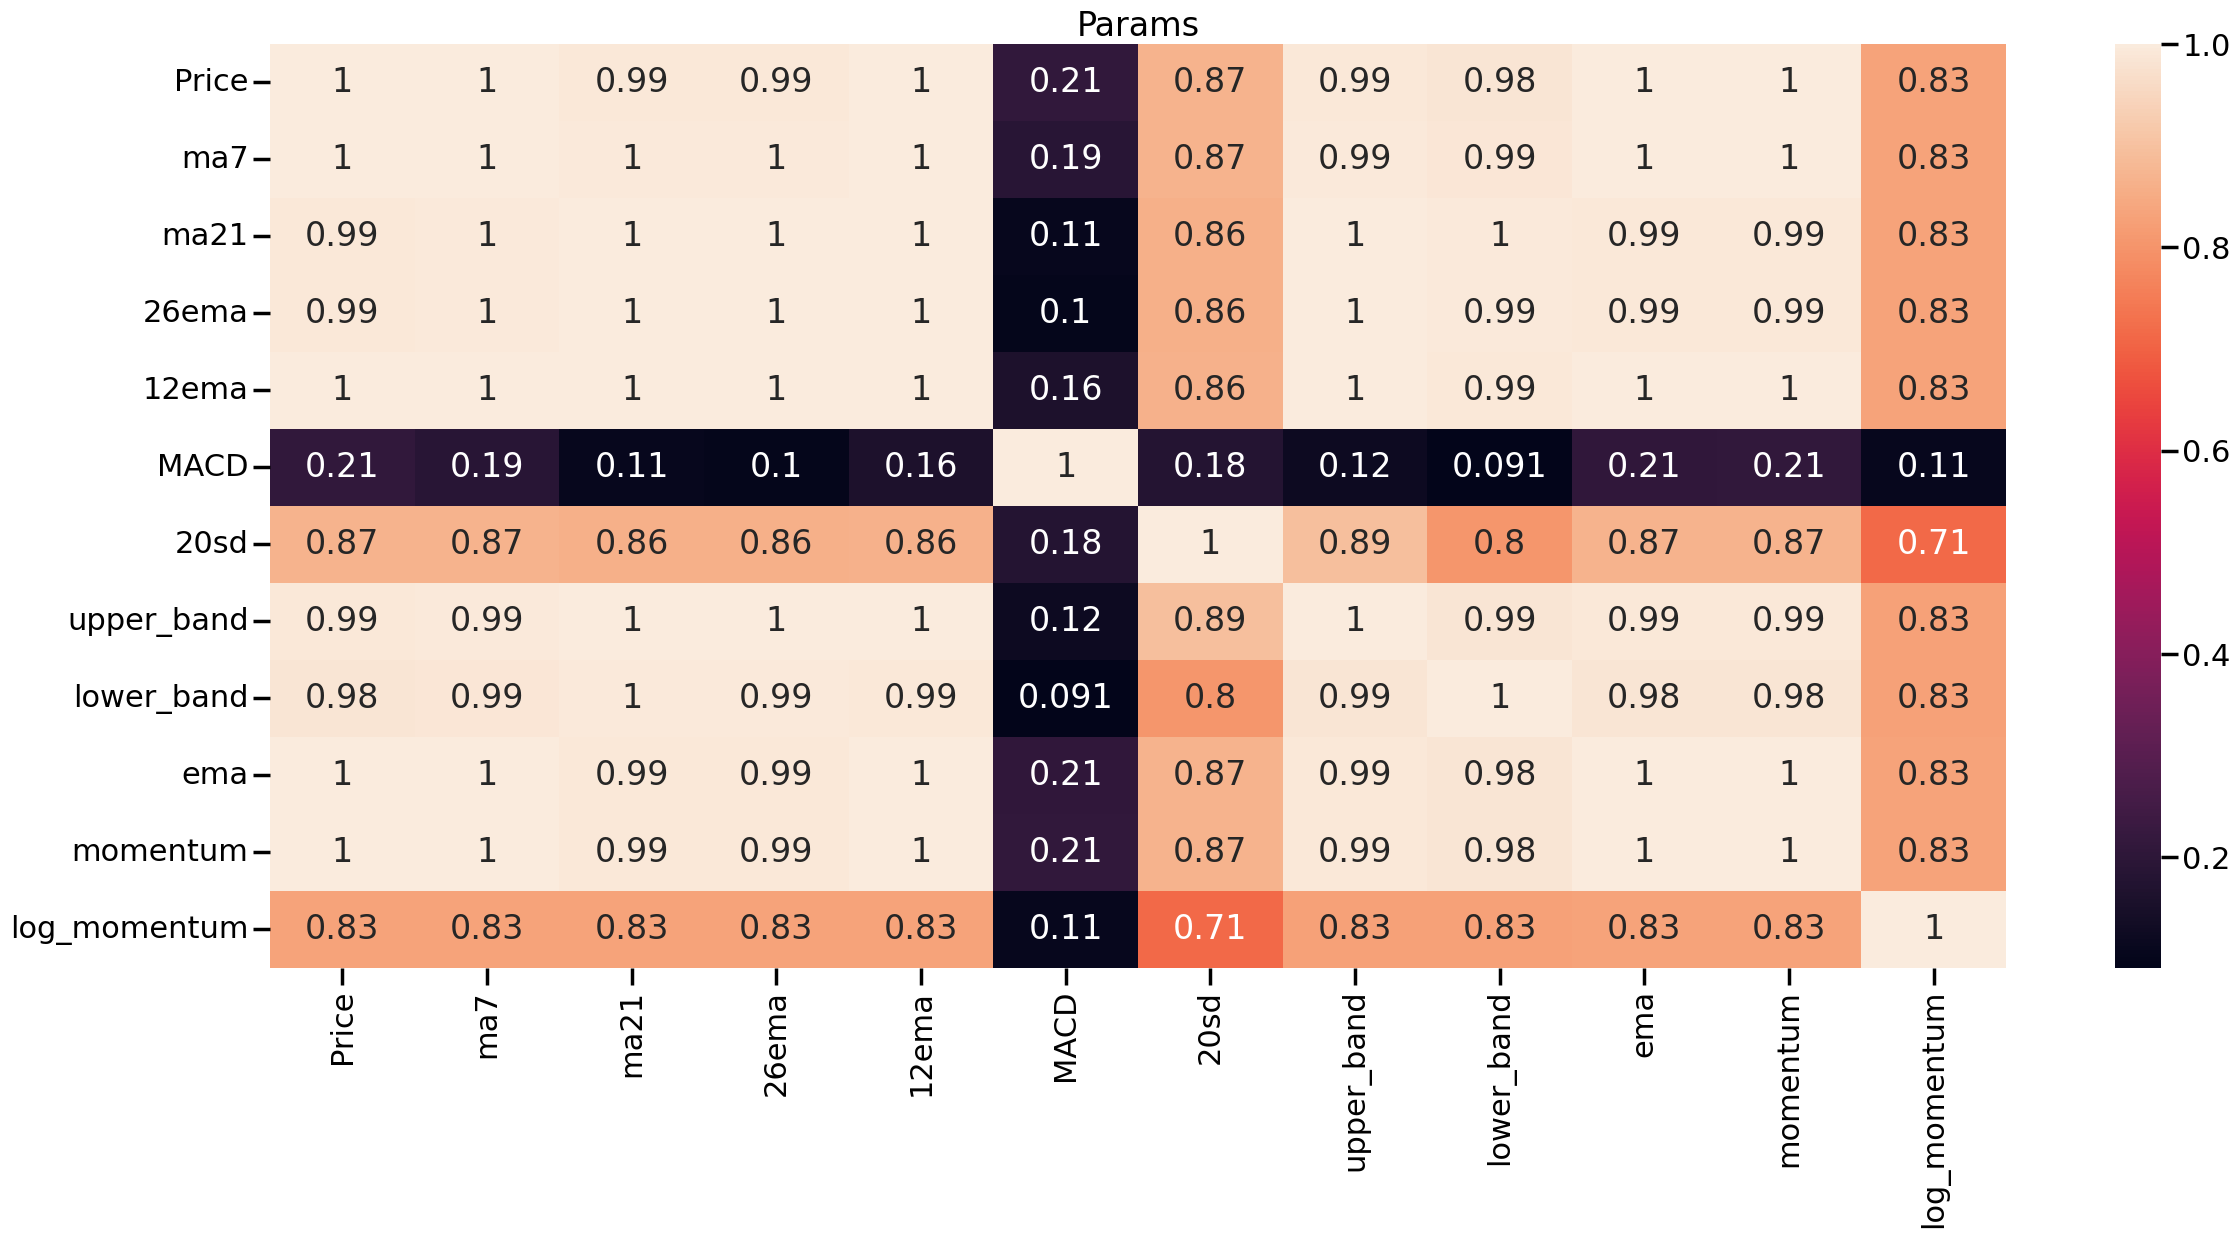

In [57]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')


In [58]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 3733 samples, and 12 features.


In [59]:
df.columns

Index(['Price', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum'],
      dtype='object')

In [60]:
df

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2010-07-28,1.381333,1.381238,1.327460,1.340849,1.360547,0.019699,0.149731,1.626922,1.027999,1.380945,0.381333,-0.964082
2010-07-29,1.356667,1.381714,1.316222,1.342285,1.359935,0.017650,0.137159,1.590540,1.041904,1.364760,0.356667,-1.030953
2010-07-30,1.329333,1.379048,1.303873,1.341128,1.355124,0.013995,0.122269,1.548411,1.059335,1.341142,0.329333,-1.110686
2010-08-02,1.394667,1.378286,1.300571,1.345837,1.361320,0.015483,0.118611,1.537793,1.063350,1.376825,0.394667,-0.929713
2010-08-03,1.463333,1.384571,1.309302,1.356028,1.377259,0.021231,0.123660,1.556622,1.061981,1.434497,0.463333,-0.769309
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-22,341.040009,343.150003,306.746194,306.061125,326.768545,20.707419,30.421024,367.588243,245.904146,339.922852,340.040009,5.829063
2025-05-23,339.339996,341.958575,310.547622,308.526227,328.702614,20.176387,29.185960,368.919542,252.175702,339.534282,338.339996,5.824051
2025-05-27,362.890015,344.825718,314.259051,312.553174,333.962214,21.409040,30.685196,375.629442,252.888659,355.104770,361.890015,5.891340


**Spliting the dataset into training (70%) and testing (30%) set**

In [61]:
# Splitting data into training and testing
train = pd.DataFrame(df[0:int(len(df)*0.70)])
test = pd.DataFrame(df[int(len(df)*0.70): int(len(df))])

print(train.shape)
print(test.shape)

(2613, 12)
(1120, 12)


In [62]:
#data_training = df[df.index < '2019-01-31'].copy()
data_training = train.copy()
data_training

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2010-07-28,1.381333,1.381238,1.327460,1.340849,1.360547,0.019699,0.149731,1.626922,1.027999,1.380945,0.381333,-0.964082
2010-07-29,1.356667,1.381714,1.316222,1.342285,1.359935,0.017650,0.137159,1.590540,1.041904,1.364760,0.356667,-1.030953
2010-07-30,1.329333,1.379048,1.303873,1.341128,1.355124,0.013995,0.122269,1.548411,1.059335,1.341142,0.329333,-1.110686
2010-08-02,1.394667,1.378286,1.300571,1.345837,1.361320,0.015483,0.118611,1.537793,1.063350,1.376825,0.394667,-0.929713
2010-08-03,1.463333,1.384571,1.309302,1.356028,1.377259,0.021231,0.123660,1.556622,1.061981,1.434497,0.463333,-0.769309
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-04,199.679993,193.969522,165.283492,168.339883,183.358384,15.018501,24.628063,214.539618,116.027365,198.282092,198.679993,5.291695
2020-12-07,213.919998,197.196189,168.516349,171.716188,188.060171,16.343983,26.368697,221.253743,115.778954,208.707363,212.919998,5.360916
2020-12-08,216.626663,200.249523,172.007301,175.042890,192.455016,17.412126,27.685574,227.378450,116.636152,213.986896,215.626663,5.373549


In [63]:
#data_testing = df[df.index >= '2019-01-31'].copy()
data_testing = test.copy()
data_testing

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2020-12-11,203.330002,205.980950,181.416666,181.148629,197.280485,16.131856,25.851897,233.120460,129.712872,204.853836,202.330002,5.309900
2020-12-14,213.276672,208.192856,185.036825,183.528484,199.741437,16.212953,24.653453,234.343730,135.729920,210.469060,212.276672,5.357890
2020-12-15,211.083328,209.821904,188.604285,185.569583,201.486343,15.916760,22.559611,233.723507,143.485064,210.878572,210.083328,5.347504
2020-12-16,207.589996,208.917618,192.011904,187.200725,202.425367,15.224642,19.405248,230.822401,153.201408,208.686188,206.589996,5.330736
2020-12-17,218.633331,209.204285,195.413332,189.529066,204.918900,15.389834,17.304916,230.023163,160.803501,215.317617,217.633331,5.382812
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-22,341.040009,343.150003,306.746194,306.061125,326.768545,20.707419,30.421024,367.588243,245.904146,339.922852,340.040009,5.829063
2025-05-23,339.339996,341.958575,310.547622,308.526227,328.702614,20.176387,29.185960,368.919542,252.175702,339.534282,338.339996,5.824051
2025-05-27,362.890015,344.825718,314.259051,312.553174,333.962214,21.409040,30.685196,375.629442,252.888659,355.104770,361.890015,5.891340


In [64]:
scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)
data_training_scaled

(2613, 12)


array([[9.65406033e-04, 7.38276329e-04, 2.06722369e-04, ...,
        8.96902946e-04, 9.65406033e-04, 1.10643878e-01],
       [8.50922067e-04, 7.40625038e-04, 1.43253464e-04, ...,
        8.20842204e-04, 8.50922067e-04, 1.01260007e-01],
       [7.24054248e-04, 7.27474771e-04, 7.35091643e-05, ...,
        7.09854212e-04, 7.24054248e-04, 9.00710566e-02],
       ...,
       [1.00000000e+00, 9.81404547e-01, 9.64148128e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.29760513e-01, 9.90064736e-01, 9.80572953e-01, ...,
        9.60859173e-01, 9.29760513e-01, 9.89788576e-01],
       [9.64710072e-01, 1.00000000e+00, 1.00000000e+00, ...,
        9.71402807e-01, 9.64710072e-01, 9.94962417e-01]])

In [65]:
X_train = []
y_train = []

In [66]:
HORIZON = 3
for i in range(60, data_training.shape[0] - HORIZON):
#for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    #y_train.append(data_training_scaled[i, 0])
    y_train.append(data_training_scaled[i + HORIZON, 0])

In [67]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2550, 60, 12), (2550,))

Define the Hypermodel Builder Function

In [68]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
assert X_train.shape[0] == y_train.shape[0], "Mismatch between X and y!"

X_train shape: (2550, 60, 12)
y_train shape: (2550,)


In [69]:
def build_lstm_model(hp):
    model = models.Sequential()

    # Tune number of LSTM layers (1–3)
    num_layers = hp.Int('num_layers', 1, 3)
    for i in range(num_layers):
        # Tune units per layer
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        return_seq = (i < num_layers - 1)
        if i == 0:
            # lookback and n_features should match your preprocessing
            model.add(layers.LSTM(units,
                                   return_sequences=return_seq,
                                   input_shape=(LOOKBACK, n_features)))
        else:
            model.add(layers.LSTM(units, return_sequences=return_seq))
        # Tune dropout for each layer
        dropout_rate = hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='linear'))

    # Tune learning rate
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model

Instantiate and Run the Tuner

In [70]:
# Set LOOKBACK and n_features exactly as in your data preparation
LOOKBACK = 60  # e.g., past 60 days
n_features = X_train.shape[2]

# Instantiate BayesianOptimization tuner

tuner = kt.BayesianOptimization(
    build_lstm_model,
    objective='val_loss',
    max_trials=20,
    num_initial_points=5,
    directory='kt_logs',
    project_name='lstm_ta_opt'
)

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Define a hyperparameter for batch_size choices
batch_size_choice = kt.HyperParameters().Choice('batch_size', [32, 64, 128])

# Launch hyperparameter search

tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=batch_size_choice,
    validation_split=0.2,
    callbacks=[stop_early]
)

Trial 20 Complete [00h 01m 42s]
val_loss: 0.0027625723741948605

Best val_loss So Far: 0.002739374991506338
Total elapsed time: 00h 44m 26s


 Retrieve the Best Hyperparameters and Re-train

In [72]:
# Get the top hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", {param: best_hp.get(param) for param in best_hp.values.keys()})

Best hyperparameters: {'num_layers': 1, 'units_0': 224, 'dropout_0': 0.2, 'learning_rate': 0.000998133924240673, 'units_1': 64, 'dropout_1': 0.1, 'units_2': 256, 'dropout_2': 0.1}


In [74]:
# Get the top hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", {param: best_hp.get(param) for param in best_hp.values.keys()})

# Build the final model and fit
final_model = tuner.hypermodel.build(best_hp)
history = final_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size = best_hp.Int('batch_size', min_value=16, max_value=128, step=16),
    validation_split=0.2,
    callbacks=[stop_early]
)

Best hyperparameters: {'num_layers': 1, 'units_0': 224, 'dropout_0': 0.2, 'learning_rate': 0.000998133924240673, 'units_1': 64, 'dropout_1': 0.1, 'units_2': 256, 'dropout_2': 0.1}
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0013 - mae: 0.0249 - val_loss: 0.0080 - val_mae: 0.0501
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 9.9571e-05 - mae: 0.0075 - val_loss: 0.0049 - val_mae: 0.0382
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 6.1935e-05 - mae: 0.0059 - val_loss: 0.0070 - val_mae: 0.0471
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 5.8976e-05 - mae: 0.0058 - val_loss: 0.0045 - val_mae: 0.0362
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 4.3099e-05 - mae: 0.0049 - val_loss: 0.0039 - val_mae: 0.0333
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 3.8973e-05 - mae: 0.0047 - val_loss: 0.0040 - val_mae: 0.0338
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 3.8352e-05 - mae: 0.0047 - val_loss: 0.0040 - val_mae: 0.0338
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 3.3016e-05 - mae: 0.0043 - val_loss: 0.0044 - val_mae: 0.0365
Epoch 9/50
128/128 ━━━━━━━━━━━━

In [75]:
final_model.summary()
final_model.save('keras_model.keras')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 224)            │       212,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 637,733 (2.43 MB)

 Trainable params: 212,577 (830.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 425,156 (1.62 MB)

End LSTM opt

In [66]:
regressor = Sequential()

regressor.add(Input(shape=(X_train.shape[1], 12)))

regressor.add(LSTM(units=50, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [67]:
regressor.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 60)         │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 80)         │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,961 (706.88 KB)

 Trainable params: 180,961 (706.88 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [69]:
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 0.0144
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0035
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0021
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0010
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0010
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014
Ep

In [70]:
regressor.save('keras_model.keras')

In [76]:
past_60 = data_training.tail(60)
dt = pd.concat([past_60, data_testing], ignore_index=True)
dt

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,141.143326,135.471902,138.663809,130.973241,137.611476,6.638235,13.132860,164.929530,112.398088,142.906050,140.143326,4.942666
1,147.383331,139.084759,139.718476,132.188803,139.114838,6.926035,12.887567,165.493611,113.943341,145.890904,146.383331,4.986229
2,149.796661,142.801425,140.496634,133.493089,140.758195,7.265107,12.983479,166.463592,114.529675,148.494742,148.796661,5.002581
3,141.410004,145.254283,140.722571,134.079527,140.858474,6.778947,12.954725,166.632021,114.813121,143.771583,140.410004,4.944567
4,126.786667,143.384759,140.365746,133.539315,138.693580,5.154265,13.241085,166.847916,113.883575,132.448306,125.786667,4.834587
...,...,...,...,...,...,...,...,...,...,...,...,...
1175,341.040009,343.150003,306.746194,306.061125,326.768545,20.707419,30.421024,367.588243,245.904146,339.922852,340.040009,5.829063
1176,339.339996,341.958575,310.547622,308.526227,328.702614,20.176387,29.185960,368.919542,252.175702,339.534282,338.339996,5.824051
1177,362.890015,344.825718,314.259051,312.553174,333.962214,21.409040,30.685196,375.629442,252.888659,355.104770,361.890015,5.891340
1178,356.899994,345.814287,317.640955,315.838124,337.491104,21.652980,31.308403,380.257761,255.024149,356.301586,355.899994,5.874650


In [77]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

(1180, 12)


array([[0.0888835 , 0.06400968, 0.05477936, ..., 0.08789535, 0.0888835 ,
        0.17955032],
       [0.10566853, 0.07484409, 0.05827114, ..., 0.09620432, 0.10566853,
        0.20863804],
       [0.11216017, 0.08598981, 0.06084745, ..., 0.10345266, 0.11216017,
        0.21955648],
       ...,
       [0.68536159, 0.69182987, 0.63613806, ..., 0.67859561, 0.68536159,
        0.8129945 ],
       [0.66924899, 0.69479444, 0.64733483, ..., 0.6819272 , 0.66924899,
        0.80184996],
       [0.67336454, 0.7017946 , 0.65780322, ..., 0.68587711, 0.67336454,
        0.80471429]])

In [78]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((1120, 60, 12), (1120,))

In [79]:
y_pred = final_model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [74]:
y_pred = regressor.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [80]:
y_pred

array([[0.23932779],
       [0.23863898],
       [0.24330069],
       ...,
       [0.5339615 ],
       [0.545904  ],
       [0.5526299 ]], dtype=float32)

In [81]:
scale = 1/scalar.scale_[0]

In [82]:
y_pred = y_pred*scale
y_test = y_test*scale

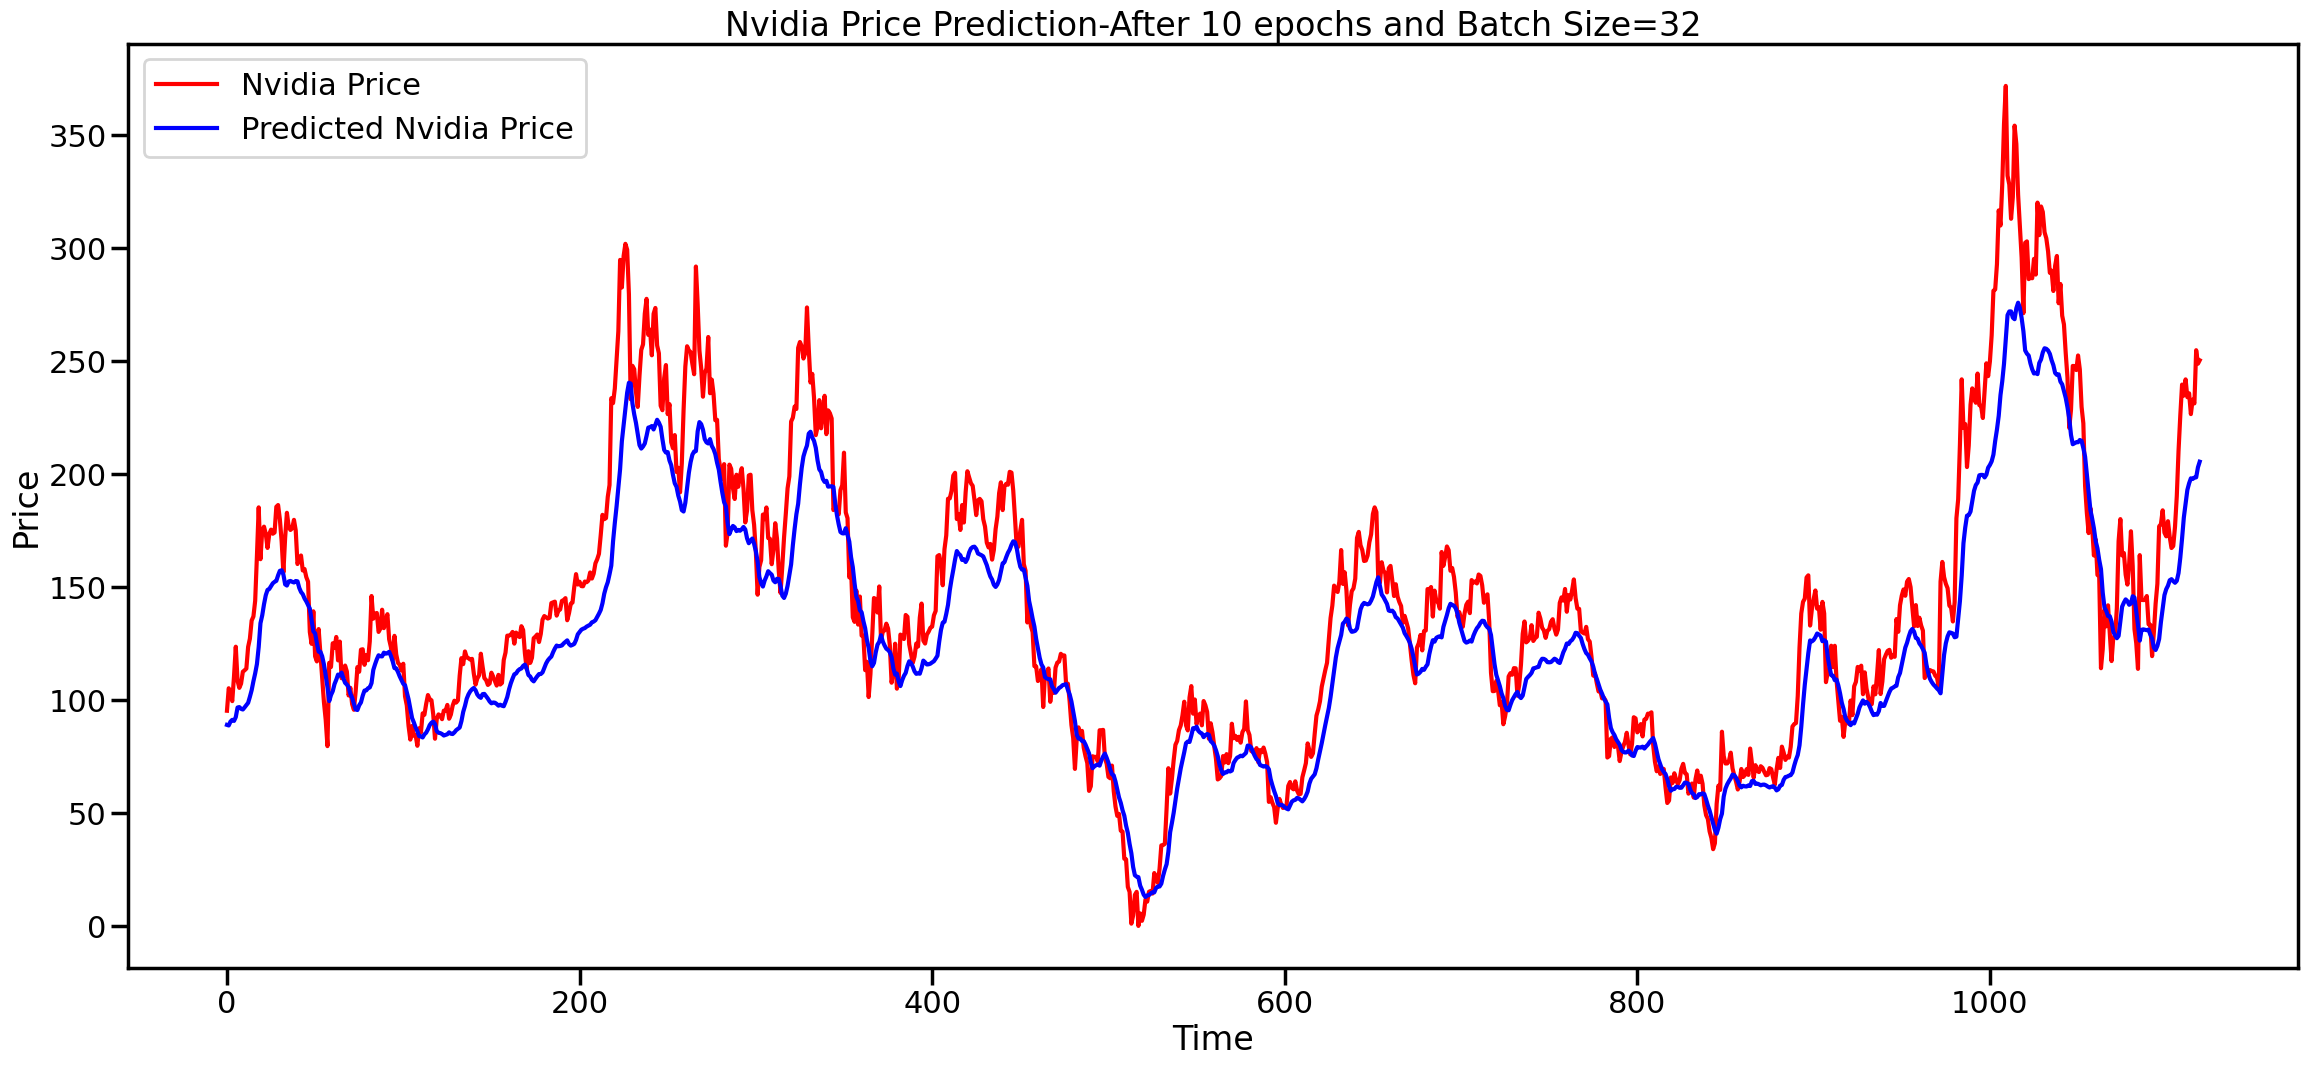

In [83]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Nvidia Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Nvidia Price')
plt.title('Nvidia Price Prediction-After 10 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

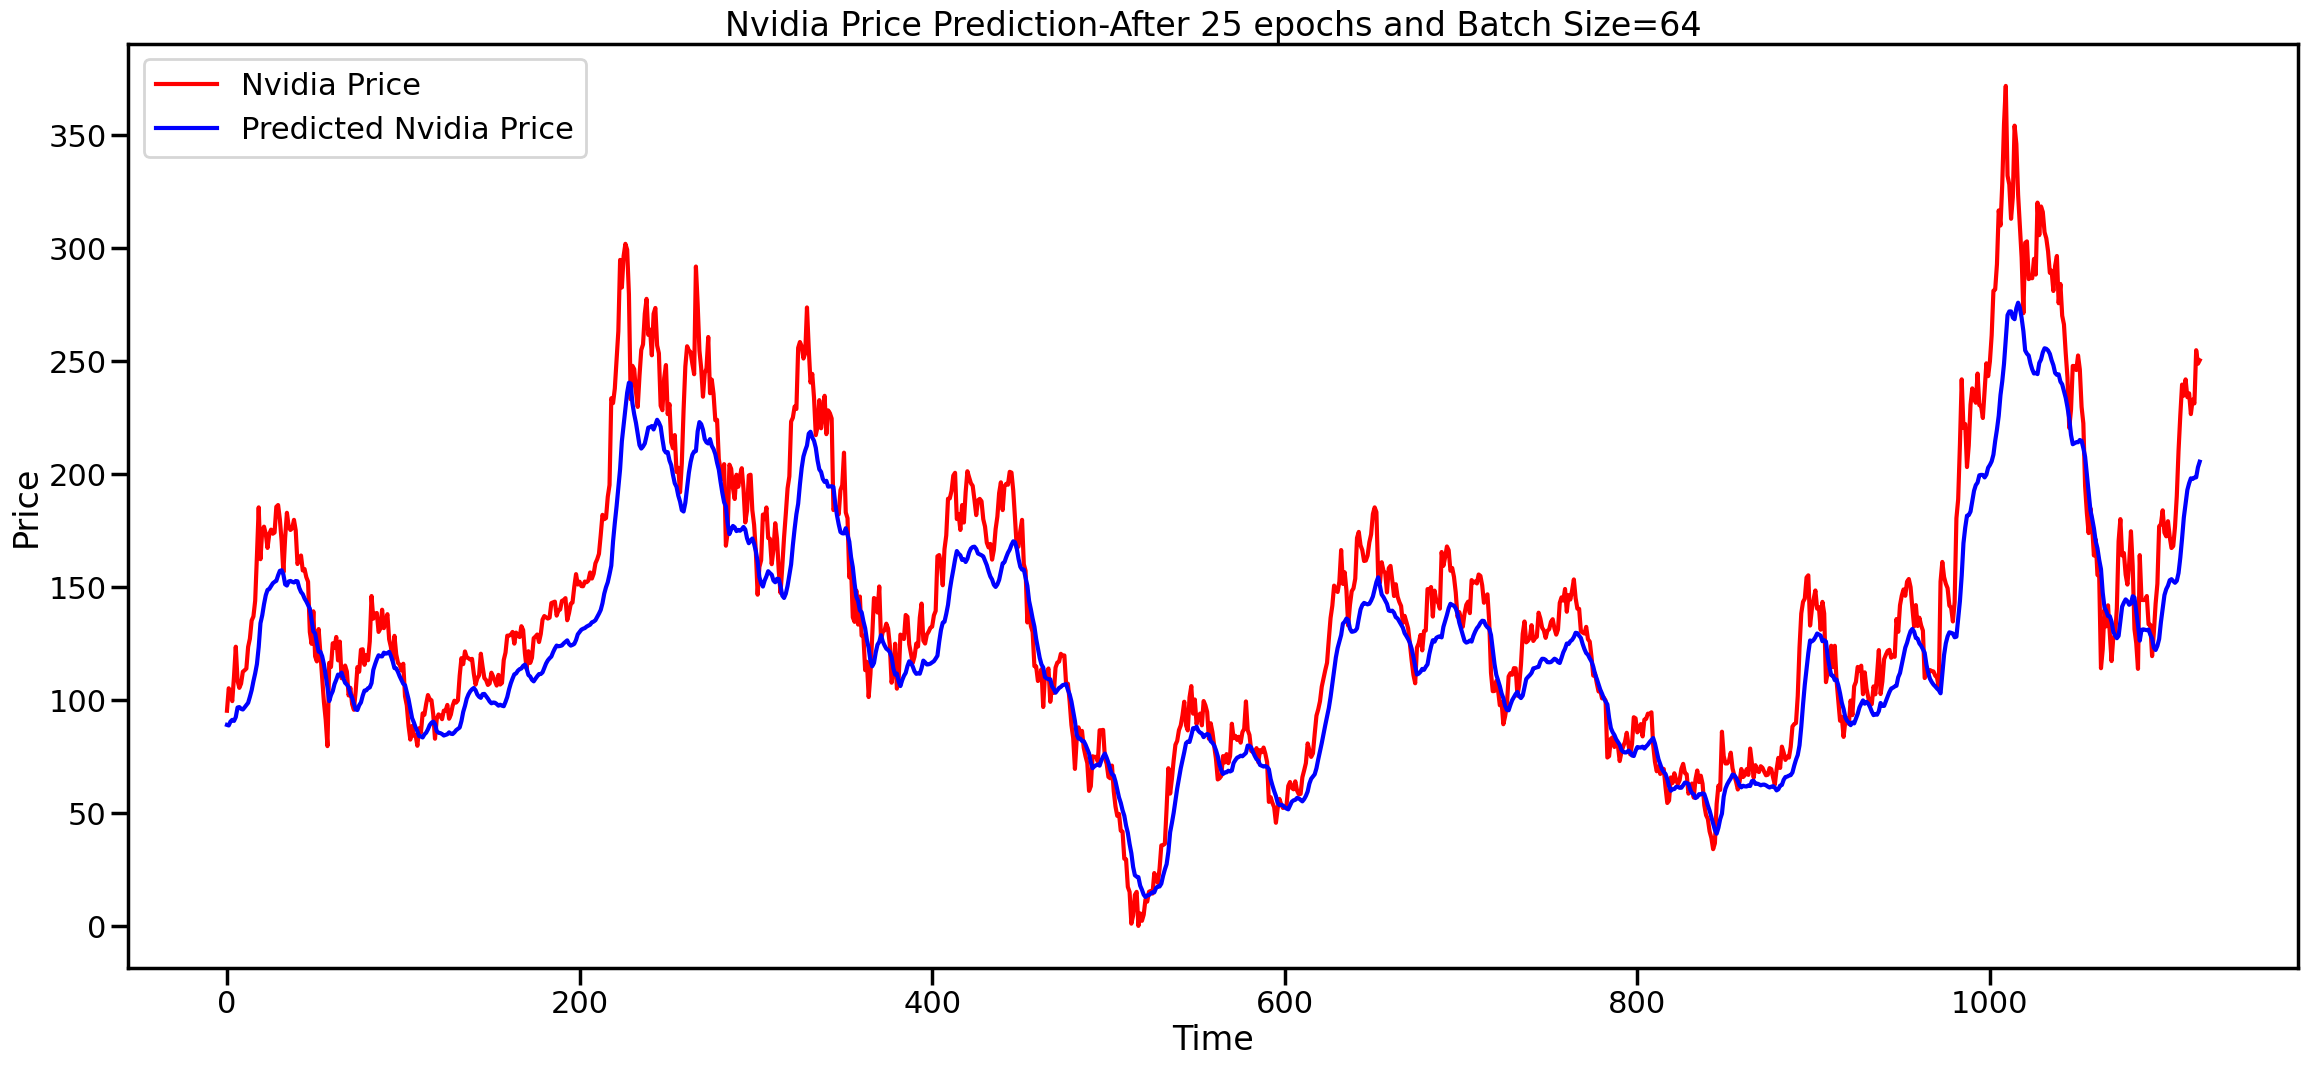

In [84]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Nvidia Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Nvidia Price')
plt.title('Nvidia Price Prediction-After 25 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

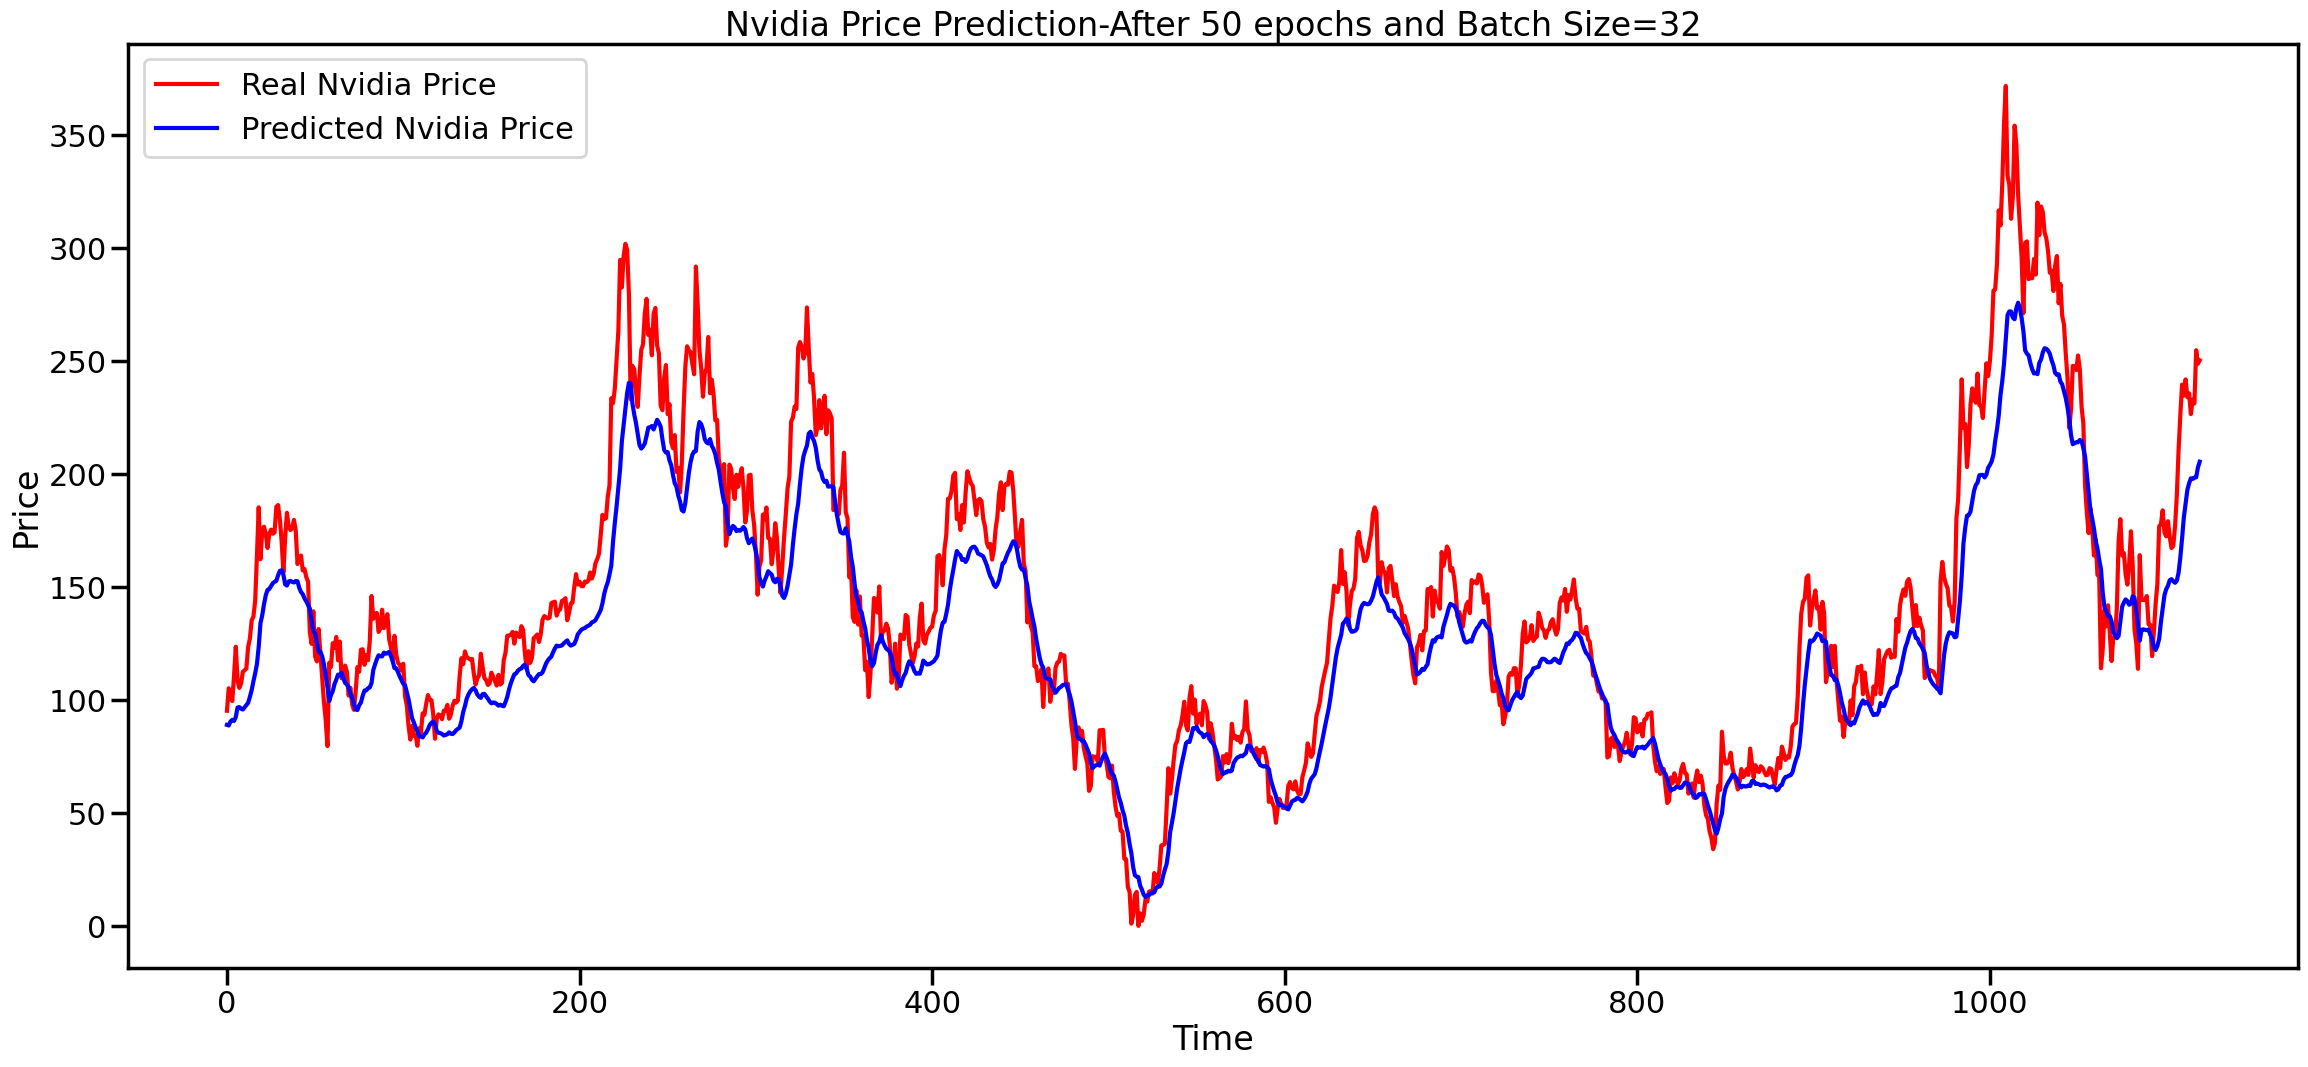

In [85]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Nvidia Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Nvidia Price')
plt.title('Nvidia Price Prediction-After 50 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### **Model evaluation**

Calculation of mean absolute error

In [86]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 13.20%


Calculation of R2 score

In [87]:
from sklearn.metrics import r2_score

# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.8494950807256043


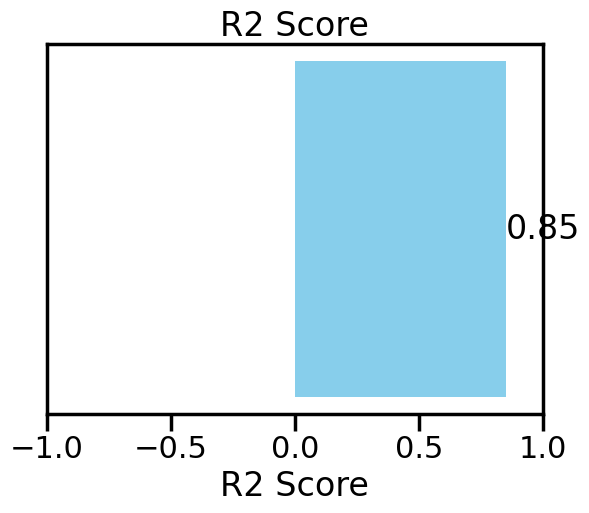

In [88]:
# Plotting the R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')

# Adding the R2 score value on the bar
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')

plt.show()

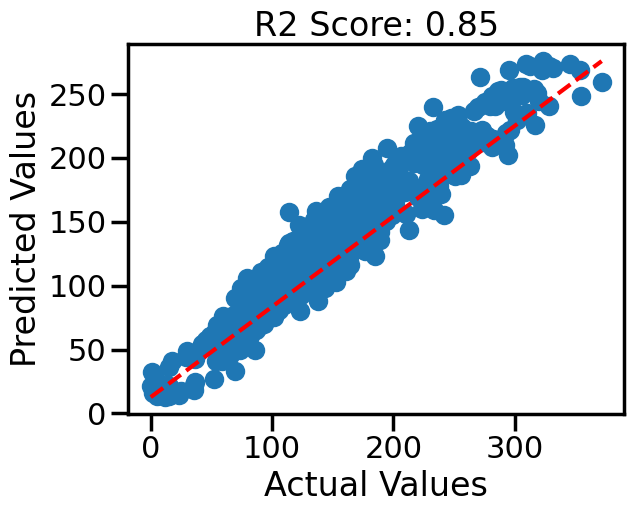

In [89]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()